This tutorial shows how to use lwreg together with machine learning experiments.

We use the registration system itself to track the compounds that have been used and a set of additional tables to track the experiments we run and their results. The primary goal is to show how little additional code is required to use the database to track results along with some of the benefits of having compounds + results in one place.

Some notes:

- The tutorial uses PostgreSQL. Everything here will work with sqlite, but some of the specifics of the code for interacting with the experiments tables will need to be updated.
- This is a tutorial, it isn't intended to be a production-quality framework for building and validating models. In the interests of having this be useful as a learning tool we skip a lot of complexity which would make this more efficient for use at scale.

In [2]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
import lwreg
from lwreg import utils,standardization_lib
import pandas as pd
import numpy as np
import rdkit
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

from rdkit.Chem import Draw

# This notebook uses the intake library (and the RDKit support for it) to read the initial data sets.
# You can find the library, along with installation instructions, here:
# https://github.com/greglandrum/intake-rdkit
import intake

import json
import uuid
from datetime import datetime



from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

# Set up the compound database

In [3]:
config = utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'lwreg_ml_tutorial'

# We standardize molecules by selecting the largest fragment and then neutralizing that;
config['standardization'] = standardization_lib.ChargeParent()

The next command should only be run at the beginning of a project since it will destroy all existing registration information.

Note that this will generate an error if the `lwreg_ml_tutorial` database doesn't already exist. You need to create it from the command line with `createdb lwreg_ml_tutorial`.

In [4]:
lwreg.initdb(config=config)
lwreg.set_default_config(config)

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


# Set up the experiments database

In [5]:
resp = input("Executing this will destroy data. Do you want to continue? [yes/no]")

if resp=='yes':
    conn = utils.connect(config)
    curs = conn.cursor()
    curs.execute('create schema if not exists experiments')
    curs.execute('drop table if exists experiments.metadata')
    curs.execute('create table experiments.metadata (expt_uid text primary key,metadata jsonb)')
    curs.execute('drop table if exists experiments.data_sets')
    curs.execute('create table experiments.data_sets (ds_uid text not null,molregnos integer array,metadata jsonb)')
    curs.execute('drop table if exists experiments.results')
    curs.execute('create table experiments.results (expt_uid text not null, ds_uid text not null,\
      split text,confusion_matrix float[2][2], accuracy float,kappa float,mcc float,auroc float,auprc float,\
      ef5 float,ef10 float,data jsonb,result_id serial primary key)')
    conn.commit()
    print('experiments schema reset')
else:
    print('cancelled')

Executing this will destroy data. Do you want to continue? [yes/no] yes


experiments schema reset


# Read in a couple of data sets

Open the data catalog from the SIMPD paper and read one of the sets of compounds:

In [7]:
catalog = intake.open_catalog('https://raw.githubusercontent.com/rinikerlab/molecular_time_series/JChemInf_publication/datasets/chemblKi_SIMPD.yaml')
simpd_name = 'CHEMBL1871-1'
ds = catalog[simpd_name]
ds.metadata

{'url': 'https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1871/',
 'source': 'ChEMBL_32',
 'organism': 'Homo sapiens',
 'assay_organism': 'Homo sapiens',
 'assay_bao_format': 'BAO_0000219',
 'activity_type': 'Ki',
 'min pchembl_value': 5.21,
 'max pchembl_value': 9.7,
 'median pchembl_value': 7.58,
 'is_log_data': True,
 'activity bin': 7.800000000000001,
 'Compounds': 347,
 'Num Active': 142,
 'Num Inactive': 205,
 'catalog_dir': 'https://raw.githubusercontent.com/rinikerlab/molecular_time_series/JChemInf_publication/datasets'}

,mol,canonical_smiles,compound_chembl_id,pchembl_value,active,split
0,,O=c1cc(C(F)(F)F)c2c(ccc3c2oc(=O)c2cccc(O)c23)[...,CHEMBL257751,8.52,1,test
1,,Cc1c(N2C(=O)[C@@H]3C[C@H](O)CN3S2(=O)=O)ccc(C#...,CHEMBL391769,7.36,0,train
2,,Cc1cc(N2C(=O)[C@@H]3C4CCC(O4)[C@@H]3C2=O)ccc1Cl,CHEMBL255367,7.11,0,train
3,,CC(c1ccc(F)cc1)(c1c[nH]c2c(NS(C)(=O)=O)cccc12)...,CHEMBL1672542,6.66,0,train
4,,O=c1cc(C(F)(F)F)c2cc3c(cc2[nH]1)OCC(C(F)F)N3CC...,CHEMBL256326,8.18,1,train

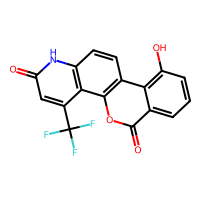
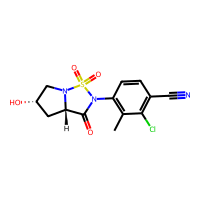
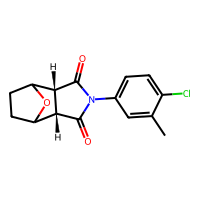
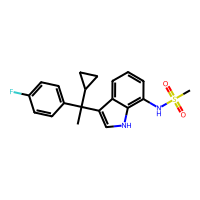
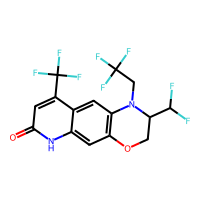

In [8]:
df = ds.read()
df.head()

Register the compounds:

In [9]:
mrns = lwreg.bulk_register(mols=df.mol.to_list(),fail_on_duplicate=False)

Register the dataset

In [10]:
ds_uid = str(uuid.uuid4())
cn = utils.connect(config=config)

chembl_target = ds.metadata["url"].split("/")[-2]
md = dict(ds.metadata)
md['dataset_source']='SIMPD'
md['SIMD name']=simpd_name
md['ChEMBL target'] = chembl_target
md['description'] = ds.description
with cn.cursor() as curs:
    curs.execute('insert into experiments.data_sets values (%s,%s,%s)',(ds_uid,list(mrns),json.dumps(md)))
    cn.commit()


Register another data set, just so there's more than one set in the registration system

In [11]:
simpd_name = 'CHEMBL217-1'
ds = catalog[simpd_name]
df = ds.read()
mrns = lwreg.bulk_register(mols=df.mol.to_list(),fail_on_duplicate=False)
chembl_target = ds.metadata["url"].split("/")[-2]
ds_uid = str(uuid.uuid4())
cn = utils.connect(config=config)
md = dict(ds.metadata)
md['dataset_source']='SIMPD'
md['SIMD name']=simpd_name
md['ChEMBL target'] = chembl_target
md['description'] = ds.description
with cn.cursor() as curs:
    curs.execute('insert into experiments.data_sets values (%s,%s,%s)',(ds_uid,list(mrns),json.dumps(md)))
    cn.commit()


# Run some experiments

In [13]:
import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,matthews_corrcoef,roc_auc_score,\
   roc_curve,precision_recall_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import math
def calc_enrichment(labels_test, test_probs, pcts=(5,10)):
    ''' function to calculate enrichment factors 
    '''
    assert(len(labels_test)==len(test_probs))
    ordering = list(np.argsort(test_probs))
    ordering.reverse()
    sorted_labels = [labels_test[x] for x in ordering]
    nPts = len(labels_test)
    nAct = sum(labels_test)
    res = {}
    for pct in pcts:
        if not nAct:
            val = 0.0
        else:
            frac = pct/100
            nExpected = nPts/nAct * frac
            nFound = sum(sorted_labels[:math.floor(frac*nPts)])
            val = nFound / nExpected
        res[f'EF{pct}'] = val
    return res


def run_ml_model(config,tgtIds,split='SIMPD',radius=2,method='RandomForest',**kwargs):
    ''' build and validate models for a set of targets and save the results to the database '''
    
    # meta data about the ML experiment:
    md = {
        'Experiment Type':'Machine learning',
        'Method': method,
        'RDKit Version': rdkit.__version__,
        'sklearn Version:': sklearn.__version__,
        'Date': str(datetime.now()),
    }

    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=2048)
    md['descriptors'] = 'count fingerprint '+fpg.GetInfoString()

    expt_uid = str(uuid.uuid4())
    rfcParams = kwargs
    md['Parameters'] = rfcParams

    # register the experiment:
    cn = utils.connect(config=config)
    with cn.cursor() as curs:
        curs.execute('insert into experiments.metadata values (%s,%s)',(expt_uid,json.dumps(md)))
        cn.commit()

    for tgtId in tgtIds:
        # get the molregnos for the data set from the database:
        with cn.cursor() as curs:
            curs.execute("select ds_uid,molregnos from experiments.data_sets where metadata->>'ChEMBL target'=%s",(tgtId,))
            row = curs.fetchone()
        ds_uid,mrns = row

        # we need to fetch the data set to get the activitity values and split column
        #  It's worth considering storing these in the local database too.
        catalog = intake.open_catalog('https://raw.githubusercontent.com/rinikerlab/molecular_time_series/JChemInf_publication/datasets/chemblKi_SIMPD.yaml')
        for k in catalog:
            if k.startswith(tgtId):
                ds = catalog[k]
        df = ds.read()
        activities = df['active'].to_list()
        simpd_split = df['split'].to_list()


        # Get the mol blocks for the molregnos in this data set and convert them to RDKit molecules:
        molblocks = lwreg.retrieve(ids=mrns)
        mols = [Chem.MolFromMolBlock(molblocks[mrn][0]) for mrn in mrns]
        
        # generate fingerprints:
        ofps = fpg.GetCountFingerprints(mols,numThreads=4)  # this function is available in RDKit versions >= 2023.09.3
        # convert those to numpy vectors so that model building is faster:
        fps = []
        for i,fp in enumerate(ofps):
            z = np.zeros(fp.GetLength(),int)
            DataStructs.ConvertToNumpyArray(fp,z)
            fps.append(z)    

        # split the data into training and test sets:
        if split=='SIMPD':
            train_fps = [fp for fp,which in zip(fps,simpd_split) if which=='train']
            test_fps = [fp for fp,which in zip(fps,simpd_split) if which=='test']
            train_acts = [act for act,which in zip(activities,simpd_split) if which=='train']
            test_acts = [act for act,which in zip(activities,simpd_split) if which=='test']
        elif split=='random':
            train_fps,test_fps,train_acts,test_acts = train_test_split(fps,activities,test_size=0.2,
                random_state=kwargs.get('random_state',None),stratify=activities)
        else:
            raise ValueError(split)

        # train our selected model type:
        if method=='RandomForest':
            cls = RandomForestClassifier(**kwargs)
        elif method=='LogisticRegression':
            cls = LogisticRegression(**kwargs)
        else:
            raise ValueError(method)
        cls = cls.fit(train_fps,train_acts)
        
        # generate predictions and predicted probabilities for the test set:
        test_preds = cls.predict(test_fps)
        test_probs = [x[1] for x in cls.predict_proba(test_fps)]

        # calculate our validation metrics:
        conf = confusion_matrix(test_acts,test_preds,labels=list(set(test_acts)))
        acc = accuracy_score(test_acts,test_preds)
        kappa = cohen_kappa_score(test_acts,test_preds)
        mcc = matthews_corrcoef(test_acts,test_preds)
        auroc = roc_auc_score(test_acts,test_probs)
        precision, recall, thresholds = precision_recall_curve(test_acts,test_probs)
        auprc = auc(recall,precision)
        enrich = calc_enrichment(test_acts,test_probs)

        mlResults = [conf.tolist(),acc,kappa,mcc,auroc,auprc,enrich['EF5'],enrich['EF10']]    

        # now save the validation metrics in the database:
        with cn.cursor() as curs:
            expt_row = [expt_uid,ds_uid,split]+mlResults+['{}']
            qs = ','.join(['%s']*len(expt_row))
            curs.execute(f'insert into experiments.results values ({qs})',(expt_row))
            cn.commit()
    
    

In [14]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],n_estimators=300,min_samples_split=4,min_samples_leaf=2,max_depth=10,
                 random_state=0xf00d)

In [15]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],n_estimators=300,min_samples_split=4,min_samples_leaf=2,max_depth=15,
                 random_state=0xf00d)

In [16]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_depth=15,
                 random_state=0xf00d)

In [17]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],method='LogisticRegression',max_iter=1000)

In [18]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],method='LogisticRegression',radius=1,max_iter=1000)

In [19]:
run_ml_model(config,['CHEMBL1871','CHEMBL217'],split='random',n_estimators=300,min_samples_split=4,min_samples_leaf=2,max_depth=10,
                 random_state=0xf00d)

# Look at some results

In [20]:
%load_ext sql
%config SqlMagic.named_parameters="enabled"

In [21]:
%sql postgresql://localhost/lwreg_ml_tutorial \
  select count(*) from experiments.results;


Connecting to 'postgresql://localhost/lwreg_ml_tutorial'

1 rows affected.

count
12


Look at the values in the first couple of rows of the results table.

In [23]:
d = %sql select * from experiments.results order by ds_uid,expt_uid,split
for row in d[:2]:
    for i,k in enumerate(d.keys):
        print(f' {k}: {row[i]}')
    print('-----')

Running query in 'postgresql://localhost/lwreg_ml_tutorial'

12 rows affected.

 expt_uid: 017da6f0-6f09-4525-9d29-92ae458f0046
 ds_uid: 6a1bc7a8-695f-4bab-8a14-dd3a70927da5
 split: SIMPD
 confusion_matrix: [[111.0, 6.0], [40.0, 42.0]]
 accuracy: 0.7688442211055276
 kappa: 0.4913879319924437
 mcc: 0.5302855449423597
 auroc: 0.8343756514488222
 auprc: 0.8062228050106831
 ef5: 65.92964824120604
 ef10: 74.17085427135679
 data: {}
 result_id: 4
-----
 expt_uid: 586c7579-4815-472f-aa1e-eb0c49bbeda7
 ds_uid: 6a1bc7a8-695f-4bab-8a14-dd3a70927da5
 split: SIMPD
 confusion_matrix: [[109.0, 8.0], [41.0, 41.0]]
 accuracy: 0.7537688442211056
 kappa: 0.4592691177286087
 mcc: 0.4931303177866551
 auroc: 0.8273921200750469
 auprc: 0.801338267282674
 ef5: 74.17085427135679
 ef10: 74.17085427135679
 data: {}
 result_id: 6
-----


Find parameters that yielded the best auroc value for SIMPD splits on each data set:

In [24]:
%sql select distinct on (ds_uid) ds_uid,expt_uid,auroc,\
   metadata->>'Method' method, metadata->>'Parameters' params\
   from (select * from experiments.results join experiments.metadata using (expt_uid) order by auroc desc) tmp\
   where split='SIMPD'
    


Running query in 'postgresql://localhost/lwreg_ml_tutorial'

2 rows affected.

ds_uid,expt_uid,auroc,method,params
6a1bc7a8-695f-4bab-8a14-dd3a70927da5,f0a9e849-8b35-4bec-9985-e03a257bfb0c,0.8227016885553471,RandomForest,"{""max_depth"": 10, ""n_estimators"": 300, ""random_state"": 61453, ""min_samples_leaf"": 2, ""min_samples_split"": 4}"
c351c8cd-93e7-41fe-a3a2-02551296429b,f240be1b-6990-4c36-ae41-c216714feac2,0.7596638655462185,LogisticRegression,"{""max_iter"": 1000}"


min and max MCC and kappa values for the SIMPD splits on each data set:

In [25]:
%sql select ds_uid,min(mcc) min_mcc,max(mcc) max_mcc,min(kappa) min_kappa, max(kappa) max_kappa \
   from experiments.results tmp\
   where split='SIMPD'\
   group by (ds_uid)
    


Running query in 'postgresql://localhost/lwreg_ml_tutorial'

2 rows affected.

ds_uid,min_mcc,max_mcc,min_kappa,max_kappa
6a1bc7a8-695f-4bab-8a14-dd3a70927da5,0.4207731435519047,0.5302855449423597,0.38866765274775283,0.4913879319924437
c351c8cd-93e7-41fe-a3a2-02551296429b,0.3207718441700005,0.37410614902153483,0.30711297071129706,0.33736951983298546


Correlation of MCC and kappa across all of the experiments:

In [26]:
import matplotlib.pylab as plt
%matplotlib inline

Running query in 'postgresql://localhost/lwreg_ml_tutorial'

12 rows affected.

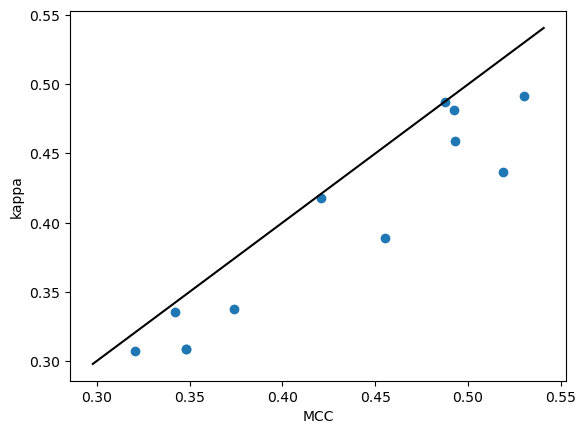

In [29]:
d = %sql select mcc,kappa from experiments.results;
x,y = zip(*d)
plt.scatter(x,y);
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
minv = min(xmin,ymin)
maxv = max(xmax,ymax)
plt.plot((minv,maxv),(minv,maxv),'k-')
plt.xlabel('MCC')
plt.ylabel('kappa');